In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/pose_estimation/AFLW2000-3D.zip

Archive:  /content/drive/MyDrive/pose_estimation/AFLW2000-3D.zip
replace AFLW2000/Code/DrawSolidHead.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mexw64  
  inflating: AFLW2000/image00002.jpg  
  inflating: AFLW2000/image00002.mat

In [4]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import os
from os import listdir
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [5]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    with faceModule.FaceMesh(static_image_mode=False) as faces:
      yaw = -yaw
      if tdx != None and tdy != None:
          tdx = tdx
          tdy = tdy
      else:
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        tdx = int(results.multi_face_landmarks[0].landmark[6].x * img.shape[1])
        tdy = int(results.multi_face_landmarks[0].landmark[6].y * img.shape[0])
        # height, width = img.shape[:2]
        # tdx = width / 2
        # tdy = height / 2

      # X-Axis pointing to right. drawn in red
      x1 = size * (cos(yaw) * cos(roll)) + tdx
      y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

      # Y-Axis | drawn in green
      #        v
      x2 = size * (-cos(yaw) * sin(roll)) + tdx
      y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

      # Z-Axis (out of the screen) drawn in blue
      x3 = size * (sin(yaw)) + tdx
      y3 = size * (-cos(yaw) * sin(pitch)) + tdy

      cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
      cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
      cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

      return img

In [6]:
def Get_Points(Img):
  # choosing random image
  # random_file = 'image00053'
  random_file = Img

  x_flat = []
  y_flat = []

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')

      # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
      mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
      # extracting the labels 3 angels
      pose_para = mat_file["Pose_Para"][0][:3]
      pitch = pose_para[0]
      yaw = pose_para[1]
      roll = pose_para[2]
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                x_flat.append(x)
                y_flat.append(y)
  # print(len(X_flatten))
  # print(len(Y_flatten))
  return x_flat , y_flat , yaw , pitch , roll

In [7]:
img_features = []
for i in range(468*2):
    img_features.append("p_{}".format(i))
img_features+= ["yaw", "pitch", "roll"]    
df = pd.DataFrame(columns= img_features)

In [8]:
data = []
images_index = []
i = 0
folder_dir = '/content/AFLW2000/'
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
      # print(images)
      i+=1
      points = Get_Points(images[:-4])
      images_index.append(images)
      data += points[0] + points[1]
      if(len(data) != 936):
        continue
      
      data.append(points[2]) 
      data.append(points[3])  
      data.append(points[4])
      # print(len(data))
      a_series = pd.Series(data , df.columns)
      df = df.append(a_series, ignore_index=True)
      
      data = []
    
df.head() 

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_929,p_930,p_931,p_932,p_933,p_934,p_935,yaw,pitch,roll
0,0.496543,0.490750,0.494637,0.473451,0.489455,0.489239,0.490431,0.349120,0.488918,0.487339,...,0.614501,0.619865,0.489245,0.494036,0.496846,0.470059,0.463056,0.066288,0.075391,-0.076080
1,0.463354,0.420435,0.460399,0.423678,0.413346,0.419647,0.449266,0.417797,0.453301,0.446881,...,0.654568,0.656145,0.492751,0.502639,0.511878,0.476429,0.457336,0.752342,-0.514121,-0.341487
2,0.513748,0.508066,0.509111,0.482511,0.506144,0.503270,0.495512,0.333096,0.489984,0.487108,...,0.649939,0.650949,0.474264,0.483180,0.491293,0.437964,0.430741,-0.027759,-0.347319,-0.091287
3,0.451924,0.441680,0.461141,0.456288,0.442326,0.452661,0.488134,0.444059,0.502825,0.505342,...,0.611855,0.615256,0.520293,0.522633,0.524878,0.536721,0.533153,0.567679,-0.029032,0.240908
4,0.430824,0.468440,0.464932,0.509696,0.481773,0.503422,0.560242,0.484615,0.599024,0.616658,...,0.570369,0.578475,0.540538,0.533655,0.527304,0.603956,0.605597,0.223025,0.442086,0.786156


In [9]:
df.shape

(1853, 939)

In [10]:
images_index

['image00972.jpg',
 'image04180.jpg',
 'image01086.jpg',
 'image00334.jpg',
 'image03075.jpg',
 'image00862.jpg',
 'image03026.jpg',
 'image00527.jpg',
 'image00726.jpg',
 'image00960.jpg',
 'image01469.jpg',
 'image00545.jpg',
 'image02592.jpg',
 'image00122.jpg',
 'image01163.jpg',
 'image03926.jpg',
 'image00082.jpg',
 'image03892.jpg',
 'image02295.jpg',
 'image03453.jpg',
 'image02073.jpg',
 'image02030.jpg',
 'image01773.jpg',
 'image00329.jpg',
 'image02080.jpg',
 'image01472.jpg',
 'image02332.jpg',
 'image01785.jpg',
 'image02038.jpg',
 'image02544.jpg',
 'image03835.jpg',
 'image02054.jpg',
 'image03624.jpg',
 'image00036.jpg',
 'image02034.jpg',
 'image01329.jpg',
 'image03791.jpg',
 'image03984.jpg',
 'image01087.jpg',
 'image02769.jpg',
 'image00734.jpg',
 'image03908.jpg',
 'image03765.jpg',
 'image00360.jpg',
 'image02739.jpg',
 'image02513.jpg',
 'image03270.jpg',
 'image04062.jpg',
 'image03977.jpg',
 'image01346.jpg',
 'image00294.jpg',
 'image03013.jpg',
 'image01762

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:936], df.iloc[:,936:], test_size=0.2, random_state=42)

In [13]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1482, 936)
(1482, 3)
(371, 936)
(371, 3)


In [14]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor

In [15]:
#yow_regressor = RandomForestRegressor(max_depth=2, random_state=0)

In [16]:
#yow_regressor.fit(X_train , y_train)

In [17]:
#yow_predictions = yow_regressor.predict(X_test)

In [18]:
#Get Accuracy
#r2_score(y_test, yow_predictions)

In [19]:
#Multi Regressor with any model
# RandomForestRegressor(max_depth=2, random_state=0)
ypr_regessor = MultiOutputRegressor(SVR())
ypr_regessor.fit(X_train , y_train)
ypr_preds = ypr_regessor.predict(X_test)

In [20]:
r2_score(y_test, ypr_preds)

0.32501556698125905

In [21]:
img_features_df_reshaped = []
points = Get_Points('image04078')
img_features_df_reshaped += points[0] + points[1]
a_series = pd.Series(img_features_df_reshaped)
img_df = pd.DataFrame(a_series)

In [22]:
img_pred = ypr_regessor.predict(img_df.T)
img_pred[0]

array([ 0.67022439, -0.06730752, -0.4047443 ])

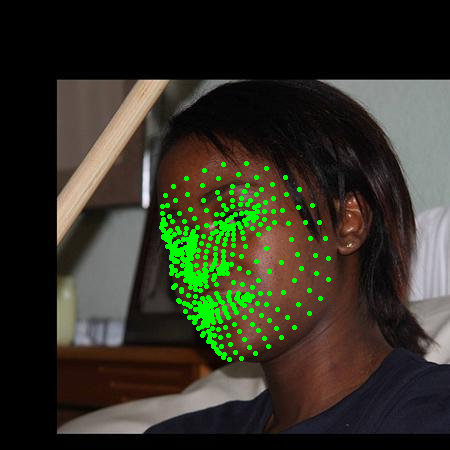

In [23]:
# choosing random image
random_file = 'image04078'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

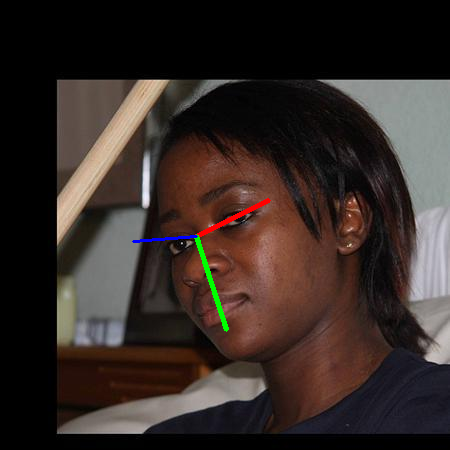

In [24]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]

yaw = img_pred[0][0]
pitch = img_pred[0][1]
roll = img_pred[0][2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

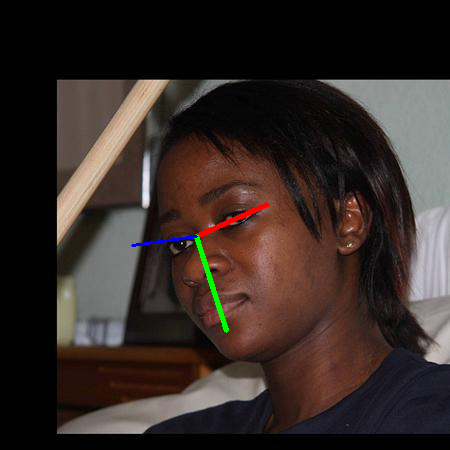

In [25]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

Video Generating

In [26]:
def draw_landmarks(img_path, landmarks):
  # random_file = img
  image = cv2.imread(img_path)
  #print(image)

  for i in range(468):
    x = landmarks[i]
    y = landmarks[i+468]
    
    shape = image.shape 
    relative_x = int(x * shape[1])
    relative_y = int(y * shape[0])
    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
  cv2_imshow(image)

In [27]:
#from skimage import io

def generate_landmarks(img_path):

  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=False) as faces:
      landmarks = []
      # loading the image
      if (type(img_path) == np.ndarray) : 
        image = img_path
      else:
        image = cv2.imread(img_path)
      #image = img_path
      #image = io.imread(img_path)
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              x_list = []
              y_list = []
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  x_list.append(x)
                  y_list.append(y)
              x_list.extend(y_list)
              landmarks.append(x_list)

  return landmarks

In [28]:
landmarks = generate_landmarks('/content/WIN_20220617_10_05_34_Pro.jpg')
landmarks = [x for xs in landmarks for x in xs]

In [29]:
len(landmarks)

936

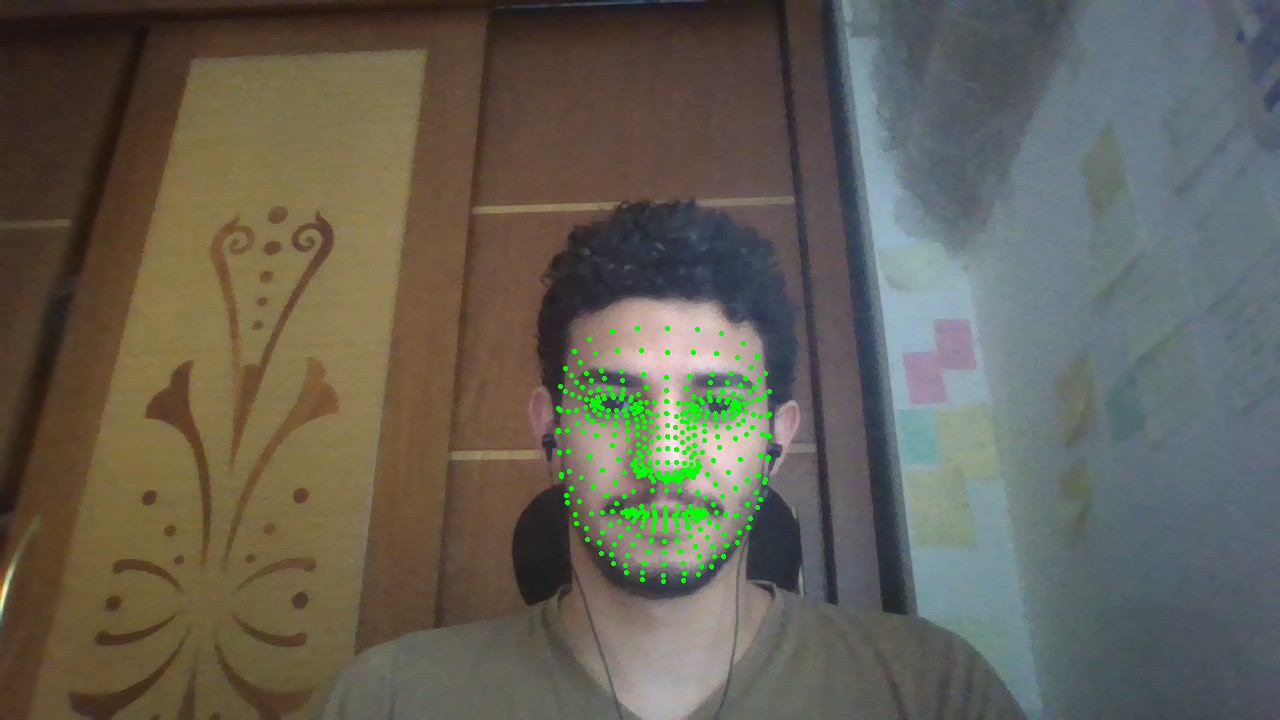

In [30]:
draw_landmarks('/content/WIN_20220617_10_05_34_Pro.jpg',landmarks )

In [31]:
def draw_pos(img_path, landmarks):
  if (type(img_path) == np.ndarray) : 
        image = img_path
  else:
        image = cv2.imread(img_path)

  ypr = ypr_regessor.predict(landmarks)

  yaw = ypr[0][0]
  pitch = ypr[0][1]
  roll = ypr[0][2]
  print(f'yaw, pitch, roll: {[ypr[0][0], ypr[0][1], ypr[0][2]]}')
  img = draw_axis(image,pitch,yaw,roll)
  return img

In [32]:
landmarks = generate_landmarks('/content/WIN_20220617_10_05_34_Pro.jpg')

In [33]:
img = draw_pos('/content/WIN_20220617_10_05_34_Pro.jpg',landmarks)

yaw, pitch, roll: [-0.03259363957273631, -0.4579735097249787, -0.03371937964798294]


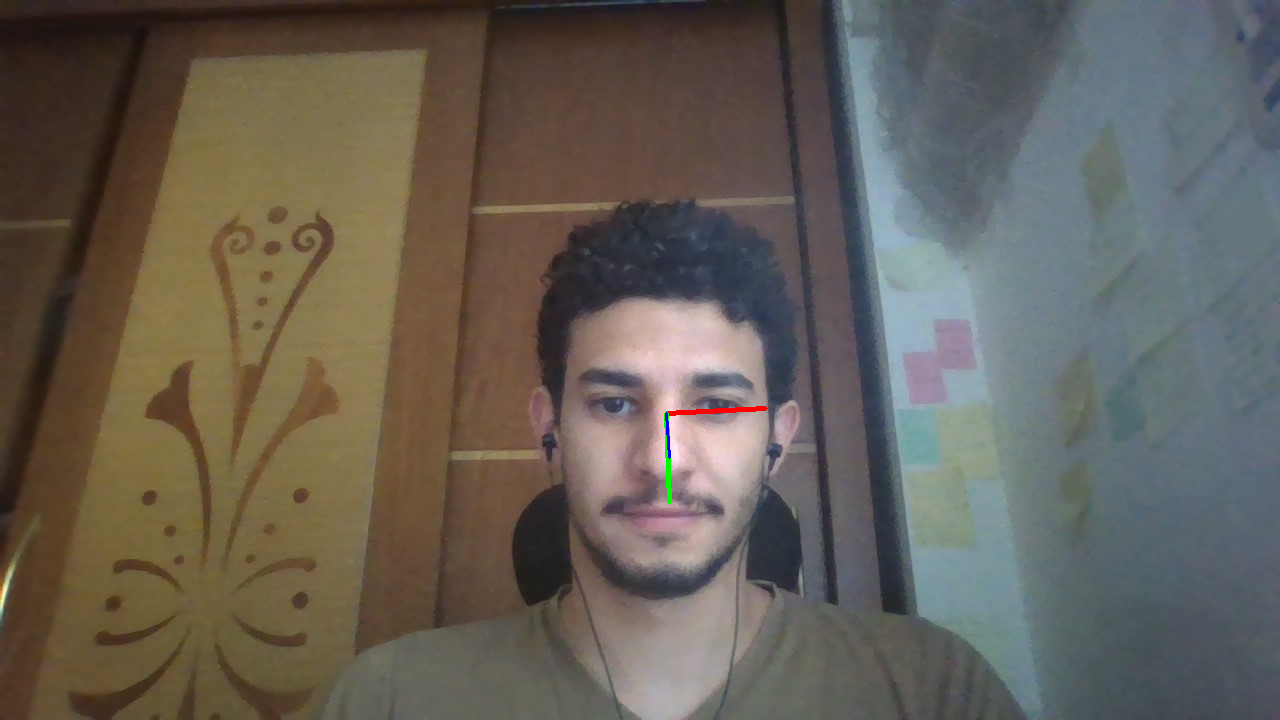

In [34]:
cv2_imshow(img)

In [35]:
vid = '/content/WIN_20220617_10_05_34_Pro.jpg'
cap = cv2.VideoCapture(vid)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(frame_count)

1


In [36]:
img_array = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
      #landmarks = generate_landmarks(frame)
      #frame = draw_pos(frame,landmarks) 
      img_array.append(frame)
      height, width, layers = frame.shape
      size  = (width,height)
    else:
      break
out = cv2.VideoWriter('/content/WIN_.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    landmarks = generate_landmarks(img_array[i])
    out.write(draw_pos(img_array[i],landmarks))
out.release()

yaw, pitch, roll: [-0.03225085118170701, -0.4532101357056529, -0.03369351625535405]
